#### Imports and Load env variables

In [1]:
import os
import requests
import json
import pathlib
from bs4 import BeautifulSoup
import re
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from pydantic import Field
from typing import List, Dict, Any
from typing import Literal
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import HumanMessage, AIMessage
from __future__ import print_function
import sib_api_v3_sdk
from sib_api_v3_sdk.rest import ApiException
from IPython.display import Markdown, display

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

#### Perform google search with Serper and Define relevance

In [3]:
search_terms = ["Agentic AI", "OpenAI  LinkedIn", "AI Agents", "Agentic AI Enterprise"]

In [4]:
class ResultRelevance(BaseModel):
    explanation: str
    id: str

class RelevanceCheckOutput(BaseModel):
    relevant_results: List[ResultRelevance]

def search_serper(search_query):
    """
    Calls Serper's Google Search API and 
    """
    url = "https://google.serper.dev/search"
    
    payload = json.dumps({
        "q": search_query,
        "gl": "gb", 
        "num": 30,
        "tbs": "qdr:d"
    })

    headers = {
        'X-API-KEY': os.environ["SERPER_API_KEY"],
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    results = json.loads(response.text)
    results_list = results['organic']

    all_results = []
    for id, result in enumerate(results_list, 1):
        result_dict = {
            'title': result['title'],
            'link': result['link'],
            'snippet': result['snippet'],
            'search_term': search_query,
            'id': id
        }
        all_results.append(result_dict)
    return all_results


def load_prompt(prompt_name):
    with open(f"prompts/{prompt_name}.md", "r") as file:
        return file.read()


def check_search_relevance(search_results: Dict[str, Any]) -> RelevanceCheckOutput:
    """
    Analyze search results and determine the most relevant ones.
    
    Args:
        search_results: Dictionary containing search results to analyze
        
    Returns:
        RelevanceCheckOutput containing the most relevant results and explanation
    """
    prompt = load_prompt("relevance")
    
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", prompt)
    ])

    llm = ChatOpenAI(model="gpt-4o", max_tokens=300).with_structured_output(RelevanceCheckOutput)
    llm_chain = prompt_template | llm
    
    return llm_chain.invoke({'input_search_results': search_results})



relevant_results = []
for search_term in search_terms:
    python_results = search_serper(search_term)
    results = check_search_relevance(python_results)
    
    # Get the relevant result IDs from the LLM output
    relevant_ids = [r.id for r in results.relevant_results]
    
    # Filter original results to only include those with matching IDs
    filtered_results = [r for r in python_results if str(r['id']) in relevant_ids]
    
    relevant_results.extend(filtered_results)

In [5]:
relevant_results

[{'title': 'How Agentic AI May Transform the Brand-Customer Relationship',
  'link': 'https://www.mytotalretail.com/article/how-agentic-ai-in-e-commerce-may-transform-the-brand-customer-relationship/',
  'snippet': 'AI agents are being developed to assist in the buying journey and provide end-to-end solutions that can complete a purchase for customers. However, as OpenAI, ...',
  'search_term': 'Agentic AI',
  'id': 4},
 {'title': 'Why Agentic AI Is the Game-Changer of 2025 - Intellitron Genesis',
  'link': 'https://intellitrongenesis.com/2025/08/27/why-agentic-ai-is-the-game-changer-of-2025/',
  'snippet': 'Why Agentic AI Is the Game-Changer of 2025, transforming industries with autonomous intelligence, reshaping workflows, and driving innovation globally.',
  'search_term': 'Agentic AI',
  'id': 5},
 {'title': "Brij kishore Pandey's Post - LinkedIn",
  'link': 'https://www.linkedin.com/posts/brijpandeyji_building-agentic-ai-systems-goes-far-beyond-activity-7366301834635788288-zmc_',


#### Scrape data from HTML and convert to markdown

In [6]:
def convert_html_to_markdown(html_content: str) -> str:
    soup = BeautifulSoup(html_content, 'html.parser')

    # paragraphs & line breaks
    for br in soup.find_all('br'):
        br.replace_with('\n')
    for p in soup.find_all('p'):
        p.insert_before('\n')
        p.insert_after('\n')

    # headers
    for h in soup.find_all(['h1','h2','h3','h4','h5','h6']):
        level = int(h.name[1])
        h.replace_with('#'*level + ' ' + h.get_text(strip=True) + '\n\n')

    # bold/italic
    for b in soup.find_all(['b','strong']):
        b.replace_with(f"**{b.get_text()}**")
    for i in soup.find_all(['i','em']):
        i.replace_with(f"*{i.get_text()}*")

    # links
    for a in soup.find_all('a'):
        href = a.get('href') or ''
        text = a.get_text(strip=True)
        a.replace_with(f'[{text}]({href})' if (href and text) else text)

    # unordered lists
    for ul in soup.find_all('ul'):
        lines = []
        for li in ul.find_all('li', recursive=False):
            lines.append(f"- {li.get_text(strip=True)}")
        ul.replace_with('\n'.join(lines) + '\n')

    # ordered lists
    for ol in soup.find_all('ol'):
        lines = []
        for idx, li in enumerate(ol.find_all('li', recursive=False), 1):
            lines.append(f"{idx}. {li.get_text(strip=True)}")
        ol.replace_with('\n'.join(lines) + '\n')

    text = soup.get_text()
    text = re.sub(r'\n{3,}', '\n\n', text).strip()
    return text

In [10]:

# def scrape_and_save_markdown(relevant_results):
#     """
#     Scrapes HTML content from URLs in relevant_results and saves as markdown files.
    
#     Args:
#         relevant_results: List of dictionaries containing search results with URLs
        
#     Returns:
#         List of dictionaries containing markdown content and metadata
#     """
#     # Create scraped_html directory if it doesn't exist
#     pathlib.Path("scraped_markdown").mkdir(exist_ok=True)

#     markdown_contents = []
#     for result in relevant_results:
#         if 'link' in result:
#             params = {
#                 "api_key": os.environ.get("SCRAPING_API_KEY"), 
#                 "url": result['link'],
#                 "render_js": "true"
#             }

#             response = requests.get("https://scraping.narf.ai/api/v1/", params=params)
            
#             if response.status_code == 200:
#                 # Create filename from ID or URL if ID not available
#                 filename = f"{result.get('id', hash(result['link']))}.md"
#                 filepath = os.path.join("scraped_markdown", filename)
                
#                 # Convert HTML to markdown
#                 markdown_content = convert_html_to_markdown(response.content.decode())
                
#                 # Save markdown content to file
#                 with open(filepath, 'w', encoding='utf-8') as f:
#                     f.write(markdown_content)
                
#                 markdown_contents.append({
#                     'url': result['link'],
#                     'filepath': filepath,
#                     'markdown': markdown_content,
#                     'title': result.get('title', ''),
#                     'id': result.get('id', '')
#                 })
#             else:
#                 print(f"Failed to fetch {result['link']}: Status code {response.status_code}")

#     print(f"Successfully downloaded and saved {len(markdown_contents)} pages as markdown to scraped_markdown/")
#     return markdown_contents

# markdown_contents = scrape_and_save_markdown(relevant_results)

In [7]:
import hashlib

class RelevantResult(TypedDict, total=False):
    id: int | str
    title: str
    link: str
    snippet: str
    search_term: str
    
def scrape_and_save_markdown(relevant_results: List[RelevantResult]) -> List[Dict[str, Any]]:
    out_dir = pathlib.Path("scraped_markdown")
    out_dir.mkdir(exist_ok=True)

    api_key = os.environ.get("SCRAPING_API_KEY")  # set this in your env
    markdown_contents: List[Dict[str, Any]] = []

    for result in relevant_results:
        url = result.get('link')
        if not url:
            continue

        params = {"api_key": api_key, "url": url, "render_js": "true"}
        try:
            resp = requests.get("https://scraping.narf.ai/api/v1/", params=params, timeout=30)
            resp.raise_for_status()
        except requests.RequestException as e:
            print(f"Failed to fetch {url}: {e}")
            continue

        # choose encoding safely
        content = resp.text

        md = convert_html_to_markdown(content)

        # stable filename
        rid = str(result.get('id', ''))
        if rid == '':
            rid = hashlib.sha1(url.encode('utf-8')).hexdigest()[:12]
        filename = f"{rid}.md"
        filepath = out_dir / filename

        filepath.write_text(md, encoding='utf-8')

        markdown_contents.append({
            "url": url,
            "filepath": str(filepath),
            "markdown": md,
            "title": result.get("title", ""),
            "id": result.get("id", "")
        })

    print(f"Successfully saved {len(markdown_contents)} pages to {out_dir}/")
    return markdown_contents

In [8]:
markdown_contents = scrape_and_save_markdown(relevant_results)

Successfully saved 20 pages to scraped_markdown/


In [10]:
markdown_contents

[{'url': 'https://www.mytotalretail.com/article/how-agentic-ai-in-e-commerce-may-transform-the-brand-customer-relationship/',
  'filepath': 'scraped_markdown\\4.md',
  'markdown': "How Agentic AI May Transform the Brand-Customer Relationship\n\n \n\nContinue to your page in 15 seconds or skip this ad.\n\n## \n\n \n\n  \n\n[Jobs](http://jobs.mytotalretail.com/)\n[Resource Guide](https://directory.mytotalretail.com)\n[Advertise](https://www.mytotalretail.com/advertising-info/)\n\n \n\nThe Retailer's Source for Content & Community\n \n\n \n\n \n\n- [Topics](#)Back To Main Menu[Topics](#)[Brick-and-Mortar](https://www.mytotalretail.com/topic/brick-and-mortar/)[E-Commerce](https://www.mytotalretail.com/topic/e-commerce/)[Management](https://www.mytotalretail.com/topic/management/)[Marketing](https://www.mytotalretail.com/topic/marketing/)[Merchandising](https://www.mytotalretail.com/topic/merchandising/)[Mobile](https://www.mytotalretail.com/topic/mobile/)[Omnichannel](https://www.mytotalre

#### Generate Summaries of Markdown

In [11]:
def generate_summaries(markdown_contents):
    """
    Generates summaries for markdown content using GPT-4.
    
    Args:
        markdown_contents: List of dictionaries containing markdown content and metadata
        
    Returns:
        List of dictionaries containing summaries and URLs
    """
    # Create markdown_summaries directory if it doesn't exist
    pathlib.Path("markdown_summaries").mkdir(exist_ok=True)

    # Load the summary prompt
    summary_prompt = load_prompt("sum_markdown")

    # Create prompt template
    summary_template = ChatPromptTemplate.from_messages([
        ("system", summary_prompt)
    ])

    # Initialize LLM
    llm = ChatOpenAI(model="gpt-4o",temperature=0.4)
    summary_chain = summary_template | llm

    # Generate and save summaries
    summaries = []
    for content in markdown_contents:
        try:
            # Generate summary, limiting to first 2000 words
            summary = summary_chain.invoke({
                'markdown_input': ' '.join(content['markdown'].split()[:2000])
            })
            
            # Create filename for summary
            summary_filename = f"summary_{content['id']}.md"
            summary_filepath = os.path.join("markdown_summaries", summary_filename)
            
            # Save summary to file
            with open(summary_filepath, 'w', encoding='utf-8') as f:
                f.write(summary.content)
            
            # Add to summaries list
            summaries.append({
                'markdown_summary': summary.content,
                'url': content['url']
            })
                
        except Exception as e:
            print(f"Failed to summarize {content['filepath']}: {str(e)}")

    print(f"Successfully generated summaries for {len(markdown_contents)} pages in markdown_summaries/")
    return summaries


summaries = generate_summaries(markdown_contents)

Successfully generated summaries for 20 pages in markdown_summaries/


In [12]:
summaries

[{'markdown_summary': '# Summary of "How Agentic AI in E-Commerce May Transform the Brand-Customer Relationship"\n\nThe article, authored by Greg Zakowicz, explores the transformative potential of agentic AI in the e-commerce sector and its implications for the brand-customer relationship. As AI technologies, particularly agentic AI, continue to evolve, they are poised to significantly alter how consumers interact with brands and make purchasing decisions.\n\n## Key Points:\n\n1. **Agentic AI\'s Role in E-Commerce:**\n   - Agentic AI is a rapidly advancing area within artificial intelligence that is gaining prominence in e-commerce.\n   - AI agents are being developed to assist consumers throughout their buying journey, offering end-to-end solutions that can even complete purchases on behalf of customers.\n\n2. **Impact on Brand-Customer Dynamics:**\n   - The introduction of AI agents raises questions about the identity of the customer. When AI agents make purchases, brands must decide

#### Defining agents using LangGraph

##### Graph State

In [13]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    summaries: List[dict]
    approved: bool
    created_summaries: Annotated[List[dict], Field(description="The summaries that have been created by the summariser")]

graph_builder = StateGraph(State)

In [14]:
# Initialize components
llm = ChatOpenAI(model="gpt-4o")

##### Summarizer Agent (Node)

In [15]:
# Load templates and prompts
with open("email_template.md", "r") as f:
    email_template = f.read()

class SummariserOutput(BaseModel):
    email_summary: str = Field(description="The summary email of the content")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

summariser_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("main_summarizer")),
    ("placeholder", "{messages}"),
])

llm_summariser = summariser_prompt | llm.with_structured_output(SummariserOutput)

def summariser(state: State):
    summariser_output = llm_summariser.invoke({"messages": state["messages"], "list_of_summaries": state["summaries"], "input_template": email_template})
    new_messages = [AIMessage(content=summariser_output.email_summary), AIMessage(content=summariser_output.message)]
    return {"messages": new_messages, "created_summaries": [summariser_output.email_summary]}

##### Reviewer Agent (Node)

In [16]:
class ReviewerOutput(BaseModel):
    approved: bool = Field(description="Whether the summary is approved or not")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

reviewer_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("reviewer")),
    ("placeholder", "{messages}"),
])


llm_reviewer = reviewer_prompt | llm.with_structured_output(ReviewerOutput)


def reviewer(state: State):
    # Convert AIMessages to HumanMessages and vice versa
    converted_messages = []
    for msg in state["messages"]:
        if isinstance(msg, AIMessage):
            converted_messages.append(HumanMessage(content=msg.content))
        elif isinstance(msg, HumanMessage):
            converted_messages.append(AIMessage(content=msg.content))
        else:
            converted_messages.append(msg)
    state["messages"] = converted_messages
    reviewer_output = llm_reviewer.invoke({"messages": state["messages"]})
    new_messages = [HumanMessage(content=reviewer_output.message)]
    return {"messages": new_messages, "approved": reviewer_output.approved}

##### Compile the graph

In [17]:
# Tie these nodes with edges

def conditional_edge(state: State) -> Literal["summariser", END]:
    if state["approved"]:
        return END
    else:
        return "summariser"


# Create and configure the graph
graph_builder.add_node("summariser", summariser)
graph_builder.add_node("reviewer", reviewer)
graph_builder.add_edge(START, "summariser")
graph_builder.add_edge("summariser", "reviewer")
graph_builder.add_conditional_edges('reviewer', conditional_edge)

# Compile and run the graph
graph = graph_builder.compile()

##### Visulalize the logic

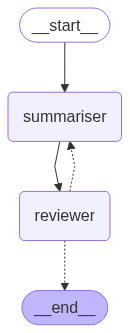

In [18]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)


##### Excecute the graph

In [19]:
output = graph.invoke({"summaries": summaries})

In [20]:
final_summary = output["created_summaries"][-1]

display(Markdown(final_summary))

<h1>🌟 Big Company Updates</h1>

<h2>🔍 Key Highlights</h2>
<ul>
<li><strong>Agentic AI in E-Commerce:</strong> With agentic AI agents stepping in as your friendly neighborhood shopping assistant, the classic brand-customer dynamics might see a romantic twist. 🤖💌 Discover more on this AI matchmaking [here](https://www.mytotalretail.com/article/how-agentic-ai-in-e-commerce-may-transform-the-brand-customer-relationship/)</li>
<li><strong>Agentic AI by 2025:</strong> Agentic AI, the superhero of 2025, promises to revolutionize industries by taking automation to autonomy! 🚀 See how [here](https://intellitrongenesis.com/2025/08/27/why-agentic-ai-is-the-game-changer-of-2025/)</li>
<li><strong>Framework for AI Systems:</strong> Get ready to deep dive into a layered approach to building AI systems. 📚🧠 Intrigued? Check it out [here](https://www.linkedin.com/posts/brijpandeyji_building-agentic-ai-systems-goes-far-beyond-activity-7366301834635788288-zmc_)</li>
<li><strong>AI Compliance and Regulation:</strong> Keep your AI in check with emerging frameworks in the ever-evolving AI landscape. 🔗 [Learn more](https://www.techtarget.com/searchenterpriseai/feature/Agentic-AI-compliance-and-regulation-What-to-know)</li>
<li><strong>Agentic AI's Economic Potential:</strong> Capgemini emphasizes on balancing trust and tech in AI to unlock immense economic value. 💹 [Read further](https://www.frontier-enterprise.com/trust-human-ai-collab-seen-defining-agentic-ai-in-next-few-years/)</li>
<li><strong>OpenAI Lawsuit Update:</strong> OpenAI ramps up its safety game after a legal hiccup. 🚨 Catch the full story [here](https://www.linkedin.com/news/story/openai-boosts-safeguards-amid-suit-6514036/)</li>
<li><strong>GPT-5 User Backlash:</strong> Users crave a friendly chat, as GPT-5 needs to work on its warmth factor—seems it lacked some emoji love! 😂 [Full insights](https://www.linkedin.com/posts/hassanbhatti_gpt-5-was-launched-as-openais-smartest-activity-7366457070658777088-r_kC)</li>
<li><strong>High-profile AI Movements:</strong> Watch the talent shuffle between AI powerhouses, with Meta and OpenAI playing musical chairs. 🎶 [Find more](https://www.financialexpress.com/trending/who-is-avi-verma-after-rishabh-agarwal-another-ai-researcher-at-meta-leaves-to-join-openai/3958644/)</li>
</ul>

<h2>🚀 Deeper Dive</h2>
<h3>1. Agentic AI's Evolving Role in E-Commerce</h3>
<p>Agentic AI is creating waves by reshaping the brand-customer landscape into one that's more data-driven and seamlessly efficient. Key players, like Amazon and OpenAI, explore how AI agents can lead transactional conversations with consumers, putting an interesting spin on traditional shopping mascots. 😄</p>

<h3>2. 2025's AI Transformation</h3>
<p>Agentic AI is not just a technology trend; it's poised to redefine productivity in industries like healthcare, finance, and retail, paving the way for cities like Mumbai to harness this power as innovation hubs. 🏙️💡</p>

<h1>📈 Industry Trends</h1>

<h2>👀 Key Highlights</h2>
<ul>
<li><strong>AWS Advances in AI:</strong> Amazon’s latest tools promising open, secure gateways for AI fans eager to get their hands dirty. 🛠️ [Explore more](https://aws-experience.com/amer/smb/e/ce7bb/building-and-operating-ai-agents-for-enterprises-the-open-way)</li>
<li><strong>Lumenova's AI Autonomy Exploration:</strong> Get on board with innovative frameworks expected to drive enterprise growth. 🌟 [Discover here](https://www.lumenova.ai/blog/ai-agents-agentic-autonomy-enterprise-growth/)</li>
<li><strong>VTEX's Enterprise Commerce Innovations:</strong> Embrace AI as your company's best assistant in the modern era of commerce. 🛒 [Read about VTEX's unique approach](https://www.newsweek.com/nw-ai/agentic-ai-power-next-generation-enterprise-commerce-2117468)</li>
<li><strong>AI Dominating IT Budgets:</strong> With big bucks pouring in, AI is in the driver’s seat—IDC says so! 💰 [Get the gist](https://www.telecomtv.com/content/digital-platforms-services/agentic-ai-to-dominate-it-budget-expansion-over-next-five-years-according-to-idc-53694/)</li>
<li><strong>Salesforce's New Agentic AI Tools:</strong> Salesforce deploys new AI benchmarks to redefine enterprise automation. 🚀 [Learn more](https://www.cio.com/article/4046713/salesforce-ai-research-unveils-new-tools-for-ai-agents.html)</li>
<li><strong>Gartner on AI in Enterprise Apps:</strong> Get ready, as AI gears up to power nearly half of your enterprise apps by 2026! 🌀 [Read more](https://itbrief.com.au/story/ai-agents-to-power-40-of-enterprise-apps-by-2026-says-gartner)</li>
<li><strong>Domo and AWS Partnership:</strong> Bridging enterprise AI gaps, this dynamic duo enhances workflow magic! 🔮 [Discover the story](https://www.ainvest.com/news/domo-aws-pioneering-agentic-ai-reshape-enterprise-automation-shareholder-2508/)</li>
</ul>

<h2>🥽 Deeper Dive</h2>
<h3>1. Industry Impact of Agentic AI</h3>
<p>AI orchestrates the next big enterprise symphony by reshaping workflows and leveling up productivity with a sprinkle of autonomy. From workflow ensemble to decision-making filigree, agentic AI ensures no beat is missed. 🎶</p>

<h3>2. AI Advances in Operations</h3>
<p>From Salesforce's benchmarks paving new roads to VTEX reshaping enterprise dynamics, the AI landscape is ripe with potential and brimming with next-gen horizons. 🌅 Dive into strategic partnerships like Domo and AWS, pioneering the pathways for tomorrow’s enterprise solutions.</p>


#### Send the email

In [24]:
def send_email(email_content: str):
    """Send email using Sendinblue API"""
    configuration = sib_api_v3_sdk.Configuration()
    configuration.api_key['api-key'] = os.getenv("SENDINBLUE_API_KEY")
    
    api_instance = sib_api_v3_sdk.TransactionalEmailsApi(sib_api_v3_sdk.ApiClient(configuration))
    
    email_params = {
        "subject": "Daily AI Research Summary",
        "sender": {"name": "Amal Thomas", "email": "reachthomas98@gmail.com"},
        "html_content": email_content,
        "to": [{"email": "reachthomas98@gmail.com", "name": "Amal Thomas"}],
        "params": {"subject": "Daily AI Research Summary"}
    }
    
    send_smtp_email = sib_api_v3_sdk.SendSmtpEmail(**email_params)
    
    try:
        api_response = api_instance.send_transac_email(send_smtp_email)
        print(api_response)
    except ApiException as e:
        print(f"Exception when calling SMTPApi->send_transac_email: {e}\n")

In [25]:
# from sib_api_v3_sdk.rest import ApiException

# def send_email(email_content: str):
#     """Send email using Brevo/Sendinblue Transactional API."""

#     api_key = os.getenv("SENDINBLUE_API_KEY")
#     if not api_key:
#         raise RuntimeError("SENDINBLUE_API_KEY is not set in environment variables.")

#     if not api_key.startswith("xkeysib-"):
#         print("Warning: API key does not look like a Brevo v3 key (usually starts with 'xkeysib-').")

#     configuration = sib_api_v3_sdk.Configuration()
#     configuration.api_key['api-key'] = api_key  # sets the Authorization header Brevo expects

#     api_instance = sib_api_v3_sdk.TransactionalEmailsApi(
#         sib_api_v3_sdk.ApiClient(configuration)
#     )

#     # make sure email_content is HTML-ish
#     if "<html" not in email_content.lower():
#         email_content = f"<!DOCTYPE html><html><body>{email_content}</body></html>"

#     email_params = {
#         "subject": "Daily AI Research Summary",
#         "sender": {"name": "Amal Thomas", "email": "reachthomas98@gmail.com"},
#         "html_content": email_content,
#         "to": [{"email": "reachthomas98@gmail.com", "name": "Amal Thomas"}],
#     }

#     try:
#         resp = api_instance.send_transac_email(sib_api_v3_sdk.SendSmtpEmail(**email_params))
#         print("Email sent. Response:", resp)
#         return resp
#     except ApiException as e:
#         # print server message body to see exact error
#         print("Brevo API error:", e)
#         if hasattr(e, 'body'):
#             print("Response body:", e.body)
#         raise


In [26]:
send_email(final_summary)

{'message_id': '<202508242133.92898483789@smtp-relay.mailin.fr>',
 'message_ids': None}
